# Compute `SEDFRAC`

`SEDFRAC` is the fraction of each grid cell at each detpth that contains subgrid-scale bottom sediment.

This procedure has the following steps.
1. Compute mapping weights for `etopo_grid` to `ocean_grid` using ESMF `conservative` scheme.
1. At each cell in `ocean_grid`, find all contributing `etopo_grid` cells; bin the data on the model vertical grid and sum the weights at each depth.
1. Normalize the resulting matrix by dividing by the sum of the weights over depth.
1. Write netCDF file for computation of [Fe sediment flux on subgrid-scale bathymetry](Fe_sediment_flux_forcing.ipynb).


In [1]:
%matplotlib inline
import os
import tqdm

import numpy as np
import xarray as xr
import scipy.sparse as sps

import esmlab

import matplotlib.pyplot as plt

import config

## Get grid and mapping files

Here we are assuming that several grid files and a conservative mapping file between them exists.

- `etopo_grid_file.ipynb` generates the ETOPO1 SCRIP grid file
- `esmf_gen_weights.pbs` uses an MPI implementation of `ESMF_RegridWeightGen` to compute mapping files.

TODO: add code to generate grids.

In [2]:
gridfile_directory = esmlab.config.get('regrid.gridfile-directory')
gridfile_directory

'/glade/work/mclong/esmlab-regrid'

In [3]:
src_grid = 'etopo1'
dst_grid = 'POP_tx0.1v3' # 'POP_gx1v7' #

file_src_grid = f'{gridfile_directory}/{src_grid}.nc'
file_dst_grid = f'{gridfile_directory}/{dst_grid}.nc'
file_weights = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_conservative.nc'

src = xr.open_dataset(file_src_grid)
dst = xr.open_dataset(file_dst_grid)
mf = xr.open_dataset(file_weights)

In [4]:
dims_dst = tuple(dst.grid_dims.values[::-1])
dims_src = tuple(src.grid_dims.values[::-1])

n_dst = np.prod(dims_dst)
n_src = np.prod(dims_src)

Convert mapping file to sparse matrix.

In [5]:
%%time
row = mf.row.values - 1
col = mf.col.values - 1
S = mf.S.values
A = sps.csr_matrix((S, (row, col)), shape=[n_dst, n_src])

CPU times: user 2.09 s, sys: 3.35 s, total: 5.44 s
Wall time: 8 s


## Read topographic data

Read the data, set the `data_src`, mask out positive values (land) and make positive-down. Make a quick plot.

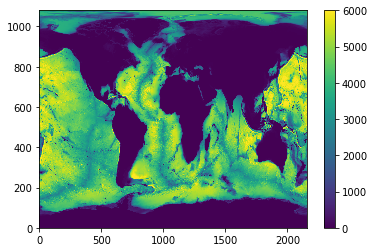

In [6]:
file_src_data = config.datasets['etopo1']['urlpath']
with xr.open_dataset(file_src_data) as ds:
    data_src = ds.z.values
    
data_src = np.where(data_src > 0., 0., -1.0 * data_src)
plt.pcolormesh(data_src[::10, ::10], vmin=0, vmax=6000.)
plt.colorbar()

Sanity check: Remap `data_src` to destination grid. Does this look like the field above?  It should.

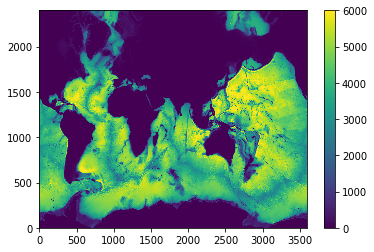

In [7]:
data_src_flat = data_src.reshape(-1, n_src)

data_dst_flat = A.dot(data_src_flat.T).T

data_dst = data_dst_flat.reshape(dims_dst)
plt.pcolormesh(data_dst, vmin=0, vmax=6000.)
plt.colorbar()

## Make the model vertical coordinate into a depth bins array

In [8]:
zbins_e = config.vert_grid_edges[dst_grid]
zbins_e[-1] = 1e20
zbins_e

array([0.00000000e+00, 1.00000000e+03, 2.00000000e+03, 3.00000000e+03,
       4.00000000e+03, 5.00000000e+03, 6.00000000e+03, 7.00000000e+03,
       8.00000000e+03, 9.00000000e+03, 1.00000000e+04, 1.10000000e+04,
       1.20000000e+04, 1.30000000e+04, 1.40000000e+04, 1.50000000e+04,
       1.60000000e+04, 1.70196808e+04, 1.80761292e+04, 1.91821243e+04,
       2.03499313e+04, 2.15923446e+04, 2.29233124e+04, 2.43584534e+04,
       2.59155793e+04, 2.76152589e+04, 2.94814713e+04, 3.15423736e+04,
       3.38312257e+04, 3.63874728e+04, 3.92580478e+04, 4.24988850e+04,
       4.61766575e+04, 5.03706883e+04, 5.51749119e+04, 6.06996663e+04,
       6.70728582e+04, 7.44398030e+04, 8.29606956e+04, 9.28043538e+04,
       1.04136820e+05, 1.17104019e+05, 1.31809363e+05, 1.48290072e+05,
       1.66499206e+05, 1.86301441e+05, 2.07487398e+05, 2.29803908e+05,
       2.52990402e+05, 2.76809851e+05, 3.01067068e+05, 3.25613847e+05,
       3.50344861e+05, 3.75189189e+05, 4.00101163e+05, 4.25052454e+05,
      

## Compute `sedfrac`

Find the points that map to each cell in the destination grid. Sum the weights from these points. 

In [9]:
%%time
data_src_flat_sq = np.squeeze(data_src_flat)

nk = len(zbins_e)-1

# sum of weights at each depth level
wsum_dst_flat = np.zeros((nk, n_dst)) 

# the data from source grid mapped to each depth level
data_dst_flat = np.zeros((nk, n_dst)) 

def getrow(sparse_matrix):
    return np.squeeze(sparse_matrix.getrow(i).toarray())

def map_point_i(i):
    
    # local slices of weights and data
    wsum_dst_flat_i = np.zeros((nk)) 
    data_dst_flat_i = np.zeros((nk)) 

    # find the points in the source grid that map to point i   
    # mapped_points = column indices of mapped points
    # w = the weights for each mapped point
    _, mapped_points, w = sps.find(A.getrow(i))

    # get the data from the source grid
    mapped_data = data_src_flat_sq[mapped_points]

    # mask out where data are not in range
    mapped_data[mapped_data <= 0] = -1
    if all(mapped_data == -1): 
        return wsum_dst_flat_i, data_dst_flat_i

    # bin the data in depth
    ind_zbin = np.searchsorted(zbins_e, mapped_data, side='left')

    # loop over mapped points and sum weights at each k-level
    for n in range(mapped_data.size):
        k = ind_zbin[n] - 1
        if k < 0: continue
        wsum_dst_flat_i[k] += w[n]
        data_dst_flat_i[k] += w[n] * mapped_data[n]
        
    return wsum_dst_flat_i, data_dst_flat_i

# loop over points in destination grid
result = []
for i in tqdm.tqdm(range(n_dst)):
    result.append(map_point_i(i))

result

100%|██████████| 8640000/8640000 [36:41<00:00, 3924.96it/s]

CPU times: user 36min 27s, sys: 21.7 s, total: 36min 49s
Wall time: 36min 41s


In [10]:
for i, (wsum, data) in enumerate(result):
    wsum_dst_flat[:, i] = wsum
    data_dst_flat[:, i] = data
    
wtot_dst_flat = wsum_dst_flat.sum(axis=0)
wtot_dst_flat = np.where(wtot_dst_flat==0., np.nan, wtot_dst_flat)
wsum_dst_flat = wsum_dst_flat / wtot_dst_flat
data_dst_flat = data_dst_flat / wtot_dst_flat

wtot_dst = wtot_dst_flat.reshape(dims_dst)
wsum_dst = wsum_dst_flat.reshape((nk,)+dims_dst)
data_dst = data_dst_flat.reshape((nk,)+dims_dst)

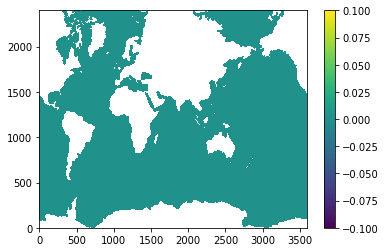

In [11]:
plt.pcolormesh(wsum_dst[50, :, :])
plt.colorbar()

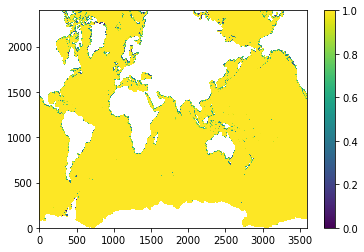

In [12]:
plt.pcolormesh(wtot_dst)
plt.colorbar()

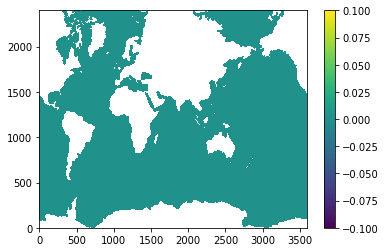

In [13]:
plt.pcolormesh(data_dst[50, :, :])
plt.colorbar()

In [14]:
dso = xr.Dataset()
dso['sedfrac'] = xr.DataArray(wsum_dst, dims=('z_t', 'nlat', 'nlon'))
dso['sum_of_weights'] = xr.DataArray(wtot_dst, dims=('nlat', 'nlon'))
dso['remapped_topography'] = xr.DataArray(data_dst, dims=('z_t', 'nlat', 'nlon'))

In [15]:
print(f'writing {config.sedfrac_file(dst_grid)}')
dso.to_netcdf(config.sedfrac_file(dst_grid))

writing /glade/work/mclong/cesm_inputdata/work/sedfrac.POP_tx0.1v3.nc
